In [2]:
import torch
from torch import nn # neural network
import matplotlib.pyplot as plt
import numpy as np
torch.__version__


'2.5.1+cu124'

## Pytorch workflow

### 1. Data (prepare and load)
### 2. Model (build)
### 3: Fitting the model to data (training)
### 4. Making predictions and evaluating a model (inference)
### 5. Saving and loading a model
### 6. Putting it all together    




## 1. Data (prepare and load) 
* excel spreadsheet
* Images
* Audio, video, DNA, text...
* --> GET DATA INTO NUMERICAL REPRESENTATION
* --> BUILD A MODEL TO LEARN PATTERNS IN DATA


### Linear regression

In [3]:
weight = 0.8
bias = 0.5

start = 0
end = 1 
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]




(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.5000],
         [0.5160],
         [0.5320],
         [0.5480],
         [0.5640],
         [0.5800],
         [0.5960],
         [0.6120],
         [0.6280],
         [0.6440]]))

## Spitting data into training and testing sets

In [4]:
train_split = int(0.8 * len(X))
print(f"Train split: {train_split}")
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)



Train split: 40


(40, 40, 10, 10)

### Data visualisation

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10,7))
    # plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    # plot test data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')
    # plot predictions in red
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
    plt.legend(prop={'size': 14})
    plt.show()



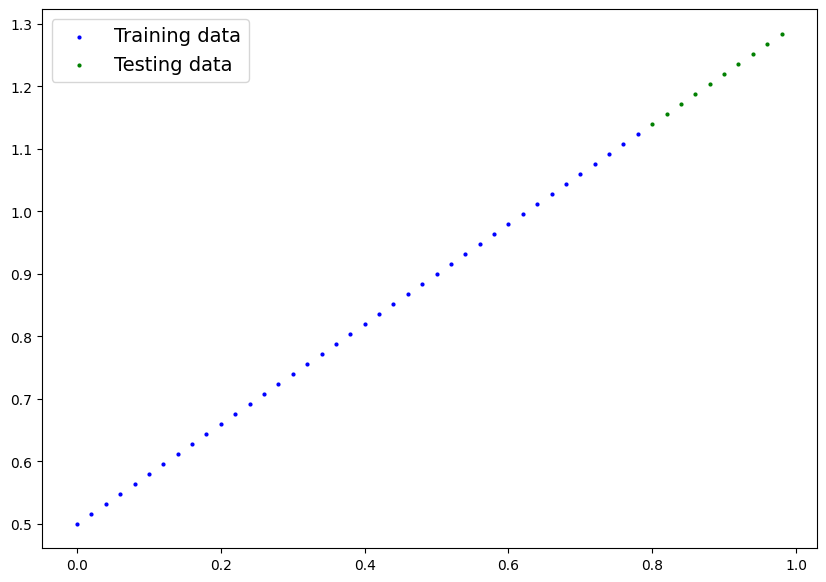

In [6]:
plot_predictions(); 

## Build model
### Linear regression model class

In [7]:
from torch import nn

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, 
                                                requires_grad=True, 
                                                dtype=torch.float),
                                   )
        self.bias = nn.Parameter(torch.randn(1, 
                                            requires_grad=True, 
                                            dtype=torch.float),
                                )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias
    
torch.manual_seed(42)
model_0 = LinearRegressionModel()
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### What the model is doing: 
* Start with random values (weight and bias)
* Look at training data and adjust the random guess (weight and bias) to better represent the data
* We want to improve the model over time
* 2 main methods: Gradient descent and backpropagation

### Pytorch model building essentials
* torch.nn - contains all of the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a Pytorch layer will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should override forward()
* torch.optim - this is where the optimizers in Pytorch are defined
* def forward() - All nn.Module subclasses require you to override forward(), this method defines the computation in the model


### Checking the contents of our Pytorch model

In [8]:
import torch

torch.manual_seed(20)
model_0 = LinearRegressionModel()

print('---> to check model parameters: list(model_0.parameters())')
print(list(model_0.parameters()))

print('---> to check model forward method: model_0.forward(torch.tensor([0.0]))')
print(model_0.forward(torch.tensor([0.0])))

print('---> to check model parameters: list(model_0.parameters())')
print(list(model_0.parameters()))

print('---> to list named parameters: model_0_state_dict')
model_0_state_dict = model_0.state_dict()
print(model_0_state_dict)


---> to check model parameters: list(model_0.parameters())
[Parameter containing:
tensor([-1.2061], requires_grad=True), Parameter containing:
tensor([0.0617], requires_grad=True)]
---> to check model forward method: model_0.forward(torch.tensor([0.0]))
tensor([0.0617], grad_fn=<AddBackward0>)
---> to check model parameters: list(model_0.parameters())
[Parameter containing:
tensor([-1.2061], requires_grad=True), Parameter containing:
tensor([0.0617], requires_grad=True)]
---> to list named parameters: model_0_state_dict
OrderedDict({'weights': tensor([-1.2061]), 'bias': tensor([0.0617])})


### The aim is to get closer to the true values of weight and bias


In [9]:
print(list(model_0.parameters())[0], list(model_0.parameters())[1])
print('---> should be approaching: weight: 0.8, bias: 0.5')


Parameter containing:
tensor([-1.2061], requires_grad=True) Parameter containing:
tensor([0.0617], requires_grad=True)
---> should be approaching: weight: 0.8, bias: 0.5


### Predictions with torch.inference_mode()

In [10]:
with torch.inference_mode():
    y_preds = model_0(X_test)

print('---> to check predictions: y_preds')
print(y_preds)
print('---> to be compared with: y_test')
print(y_test)




---> to check predictions: y_preds
tensor([[-0.9032],
        [-0.9273],
        [-0.9514],
        [-0.9756],
        [-0.9997],
        [-1.0238],
        [-1.0479],
        [-1.0720],
        [-1.0962],
        [-1.1203]])
---> to be compared with: y_test
tensor([[1.1400],
        [1.1560],
        [1.1720],
        [1.1880],
        [1.2040],
        [1.2200],
        [1.2360],
        [1.2520],
        [1.2680],
        [1.2840]])


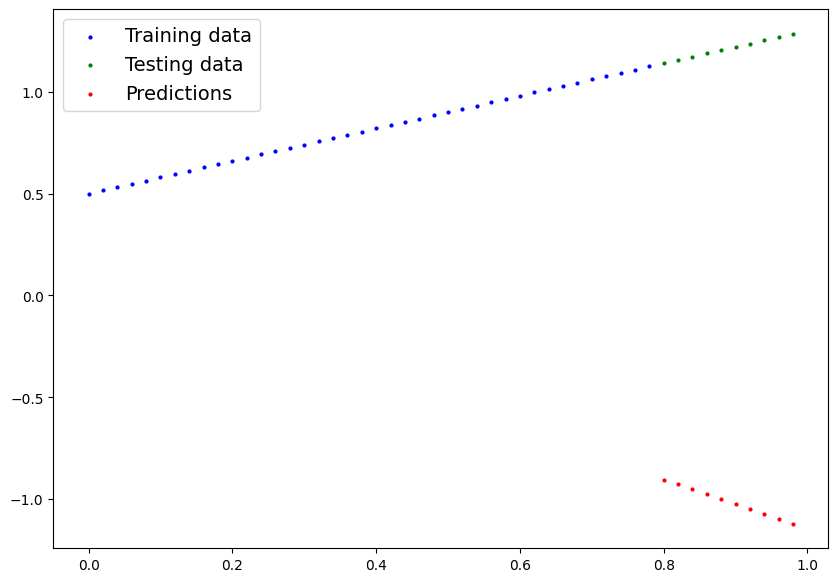

In [11]:
plot_predictions(predictions=y_preds)

## Train model
### The aim is to move from unknown parameters to known parameters, 
### Need to measure how well the model is doing with loss function = cost function = criterion

In [12]:
list(model_0.parameters())


[Parameter containing:
 tensor([-1.2061], requires_grad=True),
 Parameter containing:
 tensor([0.0617], requires_grad=True)]

In [13]:
model_0.state_dict()

OrderedDict([('weights', tensor([-1.2061])), ('bias', tensor([0.0617]))])

### For Pytorch, we need to set up a loss function and optimizer
* Loss function - how wrong the model is
* Optimizer - how the model is updated based on the data it sees and its loss function

### Need to set up: 
* Training loop
* Testing loop



### Set up a loss function

In [14]:
loss_fn = nn.L1Loss() 

### Set up an optimizer
# stochastic gradient descent: a parameter is the value that the model sets itself
optimizer = torch.optim.SGD(params=model_0.parameters(), # stochastic gradient descent
                            lr=0.01) # learning rate




### What we need for a training loop
* Loop through the data
* Forward pass: involves data moving through the model's forward() function = forward propagation
* Calculate the loss = compare forward pass prediction to ground truth labels 
* Optimizer zero grad
* Loss backward = Backpropagation: move backwards through the network to calculate the gradient of each of the parameters of our model with respect to the loss 
* Optimizer step = Gradient descent: used to adjust our model's parameters to try and improve the loss





In [17]:
print(X_train)
print(X_test)


tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800],
        [0.2000],
        [0.2200],
        [0.2400],
        [0.2600],
        [0.2800],
        [0.3000],
        [0.3200],
        [0.3400],
        [0.3600],
        [0.3800],
        [0.4000],
        [0.4200],
        [0.4400],
        [0.4600],
        [0.4800],
        [0.5000],
        [0.5200],
        [0.5400],
        [0.5600],
        [0.5800],
        [0.6000],
        [0.6200],
        [0.6400],
        [0.6600],
        [0.6800],
        [0.7000],
        [0.7200],
        [0.7400],
        [0.7600],
        [0.7800]])
tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])


In [327]:
# Epochs = loops through the data
epochs = 1000

# Loop through the data
for epoch in range(epochs):
    model_0.train() # set the model to training mode
    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train) # (input, target)
    print(f"Loss: {loss}")
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward: backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Optimizer step: gradient descent on the parameters of the model
    optimizer.step() # by default how the optimizer changes will accumulate through the loop, --> optimizer.zero_grad()

    model_0.eval()

    print(model_0.state_dict())


Loss: 0.23629672825336456
OrderedDict({'weights': tensor([-0.3749]), 'bias': tensor([0.9892])})


In [331]:
model_0.state_dict()


OrderedDict([('weights', tensor([-0.3749])), ('bias', tensor([0.9892]))])

In [332]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

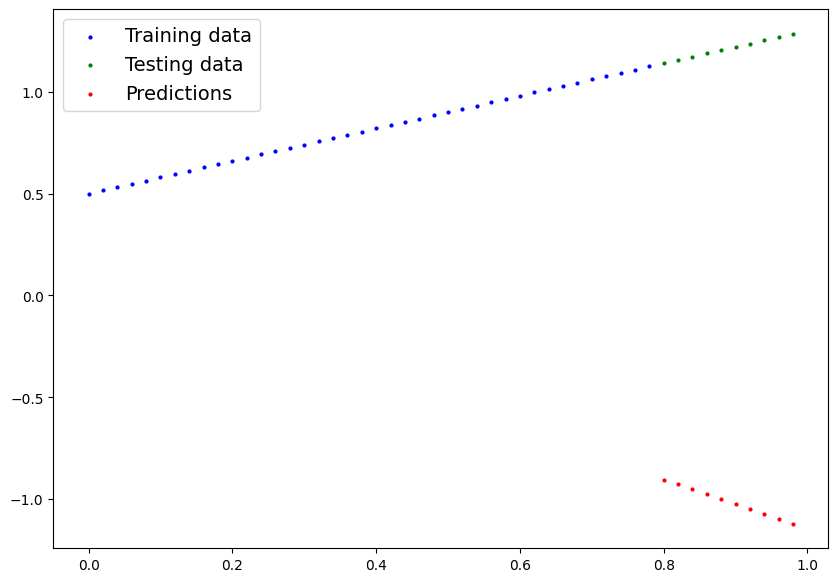

In [334]:
plot_predictions(predictions=y_preds)

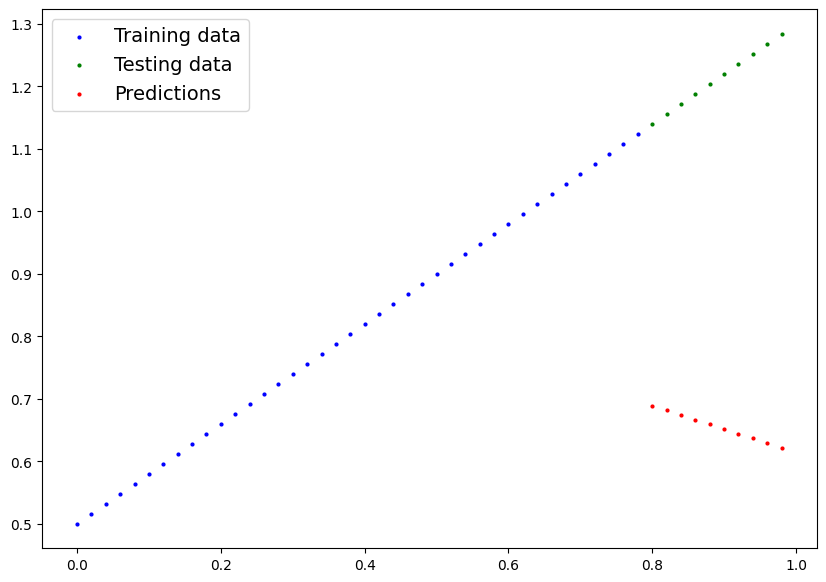

In [333]:
plot_predictions(predictions=y_preds_new)